#FlipFeed

###Objetivo:
> Identificar cuando una persona realiza una dominada correctamente

###Metodo:
> Usaremos en este caso, redes neuronales recurrentes para obtener un valor booleano

###Herramientas:

0.   Python
1.   Keras - TensorFLow
2.   Yolo v8 - entrenado con un data set personalizado
3.   OpenCV optical flow






####Montando el directorio del drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
global dirFlipfeed, dataSetPath, dirTrV, dirOut
dirFlipfeed = '/content/drive/Shareddrives/flipfeed'
dataSetPath  =  '/content/drive/Shareddrives/flipfeed/dataSetToTraining/ballAndPerson'
dirTrV = './drive/Shareddrives/flipfeed/TrainingVideos'
dirOut = './drive/Shareddrives/flipfeed/Output'

##Yolo v8 y OpenCV Optical Flow
Yolov8 lo utilizamos para etiquetar los objetos en el video. Lo entrenamos con un data set custom, podiendo así extraer las coordenadas en donde se encuentra la persona y el balón.

#### 👇 Instalamos todos los paquetes necesarios.

In [3]:
!pip install torch numpy opencv-python ultralytics supervision==0.1.0 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.4/595.4 kB 6.0 MB/s eta 0:00:00


In [4]:
# Import the necesary libraries
import torch
import numpy as np
import cv2
from time import time
from ultralytics import YOLO

from supervision.draw.color import ColorPalette
from supervision.tools.detections import Detections, BoxAnnotator
from IPython import display

 #### 👉 Entrenando Yolo v8 small con un data set custom


In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data={dataSetPath}/data.yaml epochs=25 imgsz=1599 plots=True batch=-1
# Data set custom extracted from https://universe.roboflow.com/j-h-a-blom-student-tue-nl/fbp4/dataset/1

100% 21.5M/21.5M [00:00<00:00, 32.8MB/s]
Ultralytics YOLOv8.0.112 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/Shareddrives/flipfeed/dataSetToTraining/ballAndPerson/data.yaml, epochs=25, patience=50, batch=-1, imgsz=1599, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina

#### 👍 Validando el modelo entrenado

In [ ]:
!yolo task=detect mode=val model={dirFlipfeed}/runs/detect/train/weights/best.pt data={dataSetPath}/data.yaml

Ultralytics YOLOv8.0.112 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients
val: Scanning /content/drive/Shareddrives/flipfeed/dataSetToTraining/ballAndPerson/valid/labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100% 320/320 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 20/20 [00:40<00:00,  2.05s/it]
                   all        320       1103      0.561      0.426      0.446      0.246
                  Ball        320        304      0.609      0.559      0.563      0.353
                Person        320        799      0.513      0.293      0.329       0.14
Speed: 4.5ms preprocess, 50.2ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/val2


#### Extrayendo información con cv2.calcOpticalFlowFarneback

In [ ]:
#To inference
#!yolo task=detect mode=predict model={dirFlipfeed}/runs/detect/train/weights/best.pt conf=0.25 source={dataSetPath}/test/images save=True

YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients

0: 640x384 2 persons, 1 sports ball, 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Using Device:  cuda


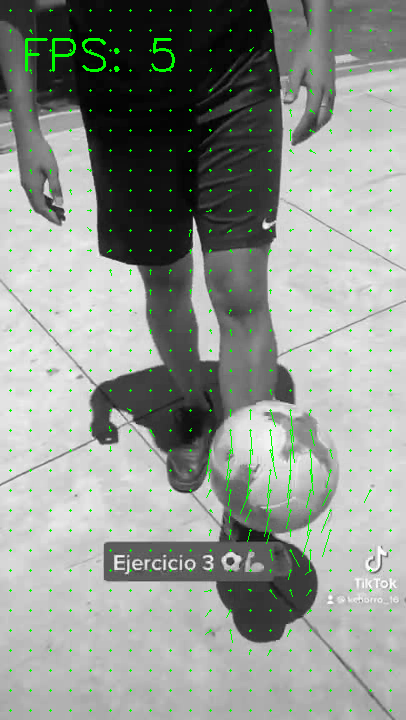


0: 640x384 2 persons, 1 sports ball, 13.2ms
Speed: 2.7ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


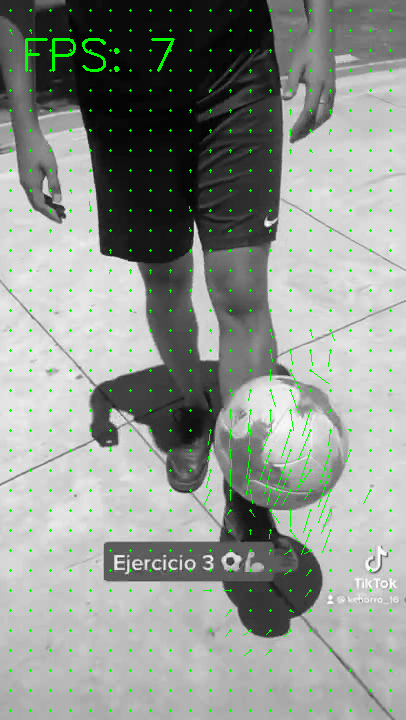


0: 640x384 2 persons, 1 sports ball, 1 skateboard, 10.3ms
Speed: 2.5ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


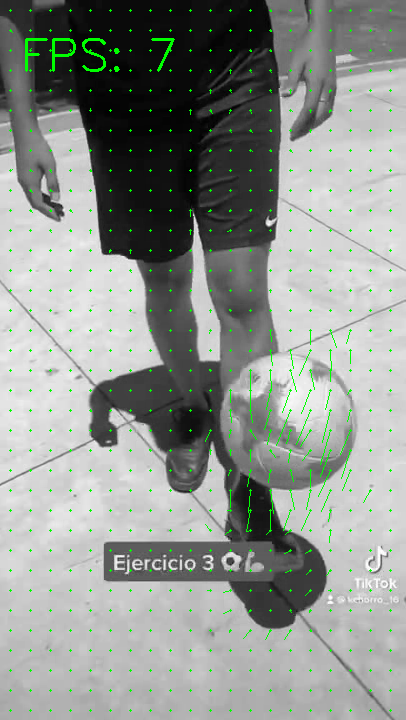


0: 640x384 2 persons, 1 sports ball, 10.6ms
Speed: 2.4ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


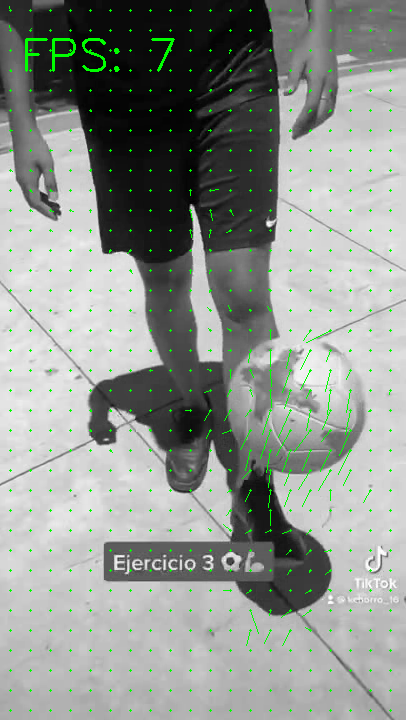


0: 640x384 2 persons, 1 sports ball, 1 skateboard, 10.5ms
Speed: 2.5ms preprocess, 10.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


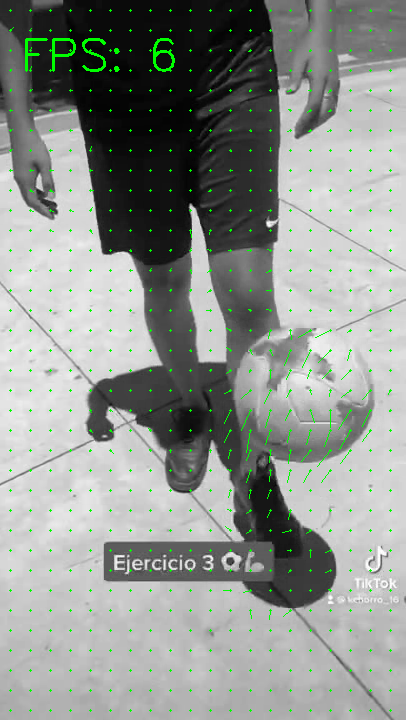


0: 640x384 2 persons, 1 sports ball, 1 skateboard, 7.8ms
Speed: 3.4ms preprocess, 7.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


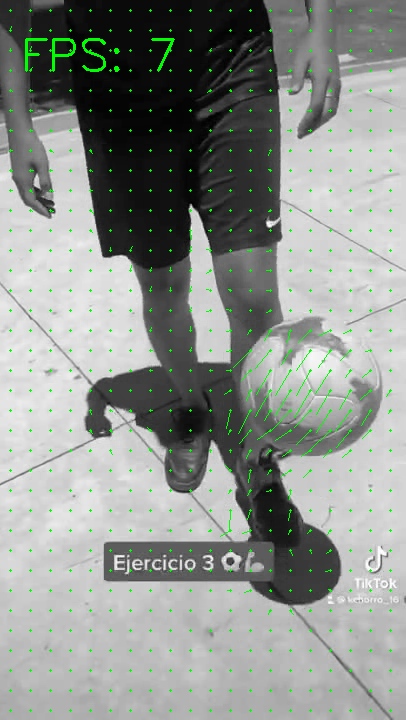


0: 640x384 2 persons, 1 sports ball, 1 skateboard, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


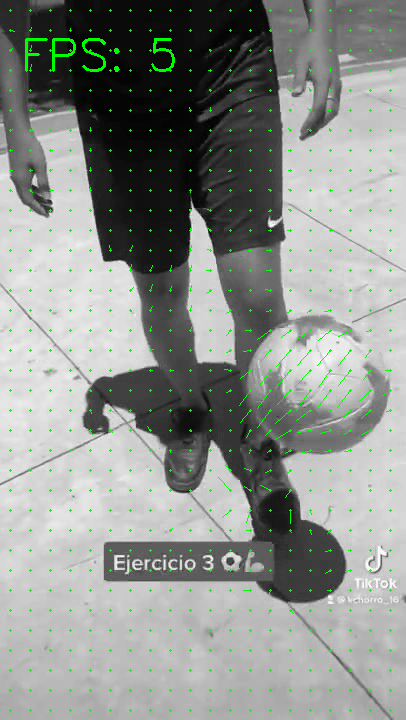


0: 640x384 2 persons, 1 sports ball, 1 skateboard, 9.4ms
Speed: 2.5ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


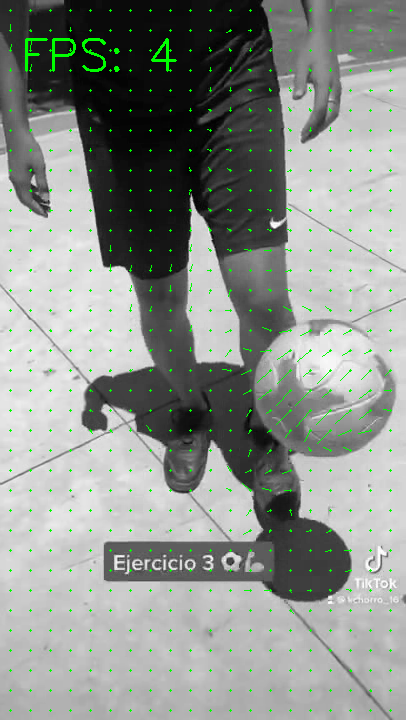


0: 640x384 2 persons, 1 sports ball, 1 skateboard, 12.5ms
Speed: 2.7ms preprocess, 12.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


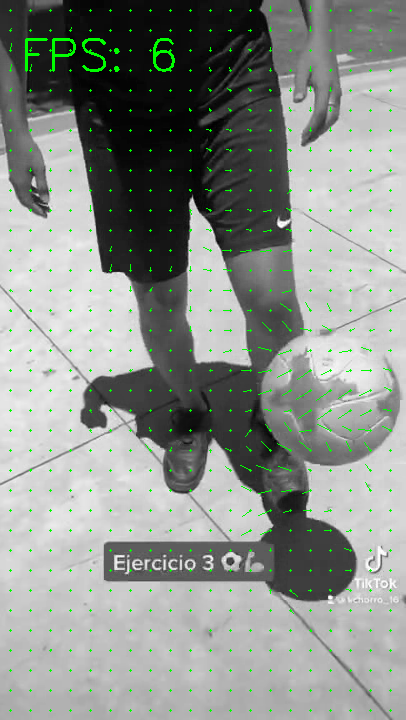


0: 640x384 2 persons, 1 sports ball, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


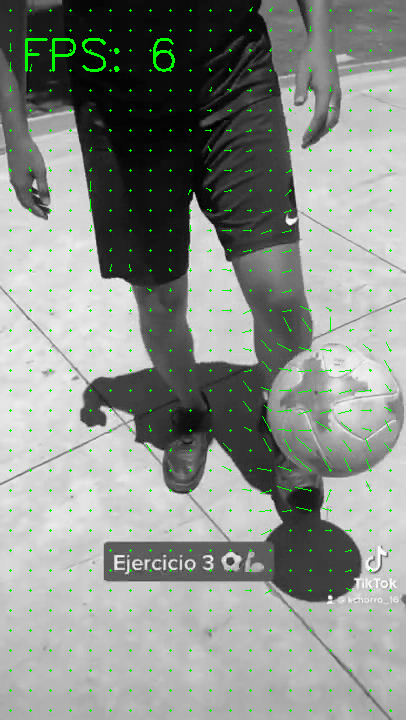


0: 640x384 2 persons, 1 sports ball, 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


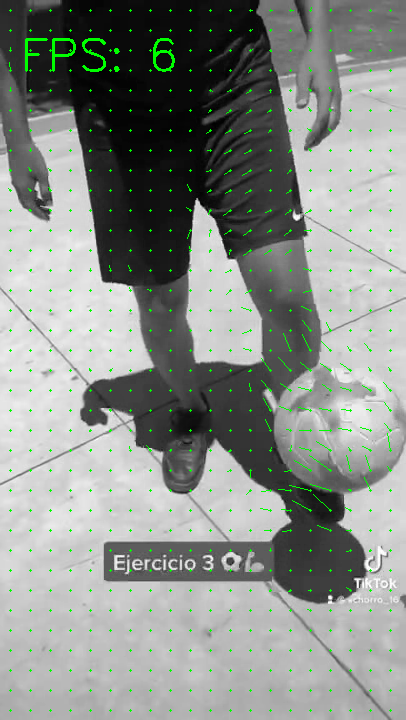


0: 640x384 2 persons, 1 sports ball, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


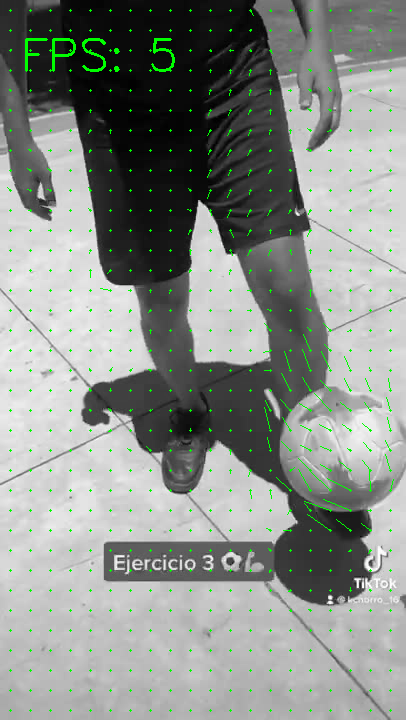


0: 640x384 2 persons, 1 sports ball, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


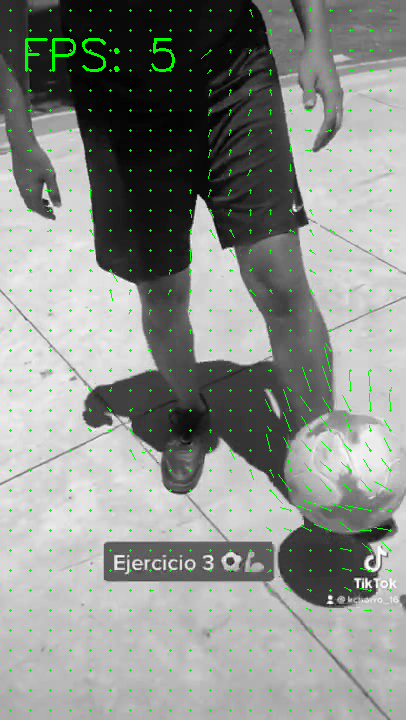


0: 640x384 2 persons, 1 sports ball, 1 skateboard, 16.2ms
Speed: 2.4ms preprocess, 16.2ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)


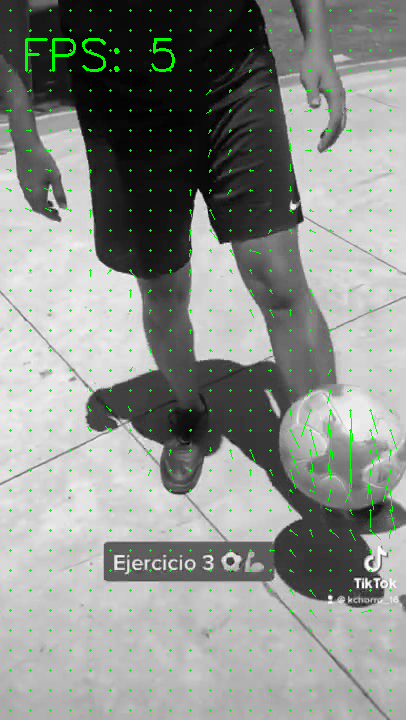

AssertionError: ignored

In [17]:
import torch
import numpy as np
import cv2
from time import time
from ultralytics import YOLO
from supervision.tools.detections import Detections
from google.colab.patches import cv2_imshow


class ObjectDetection:

    def __init__(self):

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("Using Device: ", self.device)
        
        self.model = self.load_model()
        
        self.CLASS_NAMES_DICT = self.model.model.names
    

    def load_model(self):
       
        model = YOLO(f'{dirFlipfeed}/runs/detect/train/weights/best.pt')  # load a pretrained YOLOv8n model
        model.fuse()
    
        return model


    def predict(self, frame):
       
        results = self.model(frame)
        
        return results
    

    def detecting_person_and_ball(self, results, frame):
        person = False
        ball = False
        val = False

        detections = Detections(
                    xyxy=results[0].boxes.xyxy.cpu().numpy(),
                    confidence=results[0].boxes.conf.cpu().numpy(),
                    class_id=results[0].boxes.cls.cpu().numpy().astype(int),
                    )
        for i, (xyxy, confidence, class_id, tracker_id) in enumerate(detections):
            if class_id == 0:
                person = True
            if class_id == 1:
                ball = True
        
        if person and ball:
            val = True

        return val
    

    def draw_flow(self, img, flow, step=20):

        h, w = img.shape[:2]
        y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
        fx, fy = flow[y,x].T

        lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
        lines = np.int32(lines + 0.5)

        img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cv2.polylines(img_bgr, lines, 0, (0, 255, 0))

        for (x1, y1), (_x2, _y2) in lines:
            cv2.circle(img_bgr, (x1, y1), 1, (0, 255, 0), -1)

        return img_bgr
    
    
    def __call__(self):
        
        
        videoPath = 'cut_10_Aprende1.mp4'
        cap = cv2.VideoCapture(dirFlipfeed + '/trainingVideos/train/' + videoPath)
        assert cap.isOpened()

        width  = int(cap.get(3))
        height = int(cap.get(4))
        #output = cv2.VideoWriter(dirFlipfeed + '/Striwey/Output/output_' + videoPath, cv2.VideoWriter_fourcc(*'mp4v'), 50, (width, height))

        suc, prev = cap.read()
        prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

        while True:
          
            start_time = time()
            
            ret, frame = cap.read()
            assert ret
            
            #Yolo v8
            results = self.predict(frame)
            valBool = self.detecting_person_and_ball(results, frame)

            if valBool:
                #opticalFlow
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                prevgray = gray
                frame = self.draw_flow(gray, flow)
            else:
                print('No se encuentra la persona y el balón')
            
            end_time = time()
            fps = 1/np.round(end_time - start_time, 2)
             
            cv2.putText(frame, f'FPS: {int(fps)}', (20,70), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0), 2)
            
            cv2_imshow(frame)
            #output.write(frame)
 
            if cv2.waitKey(5) & 0xFF == 27:
                break
        
        #output.release()
        cap.release()
        cv2.destroyAllWindows()
        
        
    
detector = ObjectDetection()
detector()


##Creando el data set

Lo siguiente es el código utilizado para realizar recortes a un archivo formato .mp4 donde tomaremos solo el momento en el cual se realiza la acción de "21" lo que alimentara nuestro data set de entrenamiento y test. 

In [ ]:
import cv2
from time import sleep

video = 'Aprende4.mp4'
videoPath = 'C:/Users/Acer/Documents/proyectoIA/'
a = open(videoPath + video, 'r')
input = cv2.VideoCapture(videoPath+video)

label = 1

while True:
    ret, frame = input.read()

    if not ret:
        break

    cv2.imshow('Video', frame)

    key = cv2.waitKey(5)

    if key == ord('s'):
        # Crear objeto VideoWriter para guardar el video recortado
        output = cv2.VideoWriter(f'{videoPath}/output_4/cut_{label}_{video}',
                                 cv2.VideoWriter_fourcc(*'mp4v'),
                                 30, (int(input.get(3)), int(input.get(4))))

    if key == ord('f'):
        # Liberar el objeto VideoWriter
        output.release()
        output = None
        label += 1

    try:
        output.write(frame)
    except:
        pass

    if key == ord('q'):
        break

    if key == ord('p'):
        sleep(1)

    sleep(0.1)

input.release()
cv2.destroyAllWindows()

También tendremos un script ya que habrán algunos videos que no son de utilidad, bien sea por alguna transición, porque no ahy buena iluminación o porque la acción realizada no es considerada como "21".

In [ ]:
import os

ruta_carpeta = "C:/Users/Acer/Documents/proyectoIA/output_3/"

archivos = os.listdir(ruta_carpeta)

videos = [archivo for archivo in archivos if archivo.endswith(
    (".mp4", ".avi", ".mkv"))]

videos.sort(key=lambda x: int(x.split("_")[1]))

for i, video in enumerate(videos, start=1):
    ruta_video_antigua = os.path.join(ruta_carpeta, video)
    nombre_nuevo = f"cut_{i}_{video.split('_', 2)[2]}"
    ruta_video_nueva = os.path.join(ruta_carpeta, nombre_nuevo)
    os.rename(ruta_video_antigua, ruta_video_nueva)
    print(f"Video renombrado: {ruta_video_antigua} -> {ruta_video_nueva}")

##RNN implement with Keras - Tensorflow

In [ ]:
import tensorflow as tf
import tensorflow.keras as kr
from tensorflow.keras import layers

lr = 0.01           # learning rate
nn = [2, 16, 8, 1]  # número de neuronas por capa.

model = kr.Sequential()

model.add(layers.Embedding(input_dim=1000, output_dim=64))
model.add(layers.SimpleRNN(128))
model.add(layers.Dense(10))

model.summary()

# Compilamos el modelo, definiendo la función de coste y el optimizador.
#model.compile(loss='mse', optimizer=kr.optimizers.SGD(lr=0.05), metrics=['acc'])

# Y entrenamos al modelo. Los callbacks 
#model.fit(X, Y, epochs=100)